# Amorphous structure generation

This notebook is broken down into the following components:
- Train the prior score model, which is the basis for the unconditional diffusion model.
- Load a trained prior score model, and perform unconditional generation.
- Lastly, load a trained forward model, and perform spectroscopy-guided generation.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('talk')  # optional

# I have a PyG version that prints a specific but otherwise harmless warning.
import warnings; warnings.filterwarnings('ignore', '.*TypedStorage is deprecated.*')

## Training

### Create lightning datamodule and module instances

A lot of details are hidden away for your convenience using PyTorch Lightning. They include:
- How the data is loaded, processed, batched, and so on.
- GNN model definitions.
- How the models (prior and forward) are trained, which optimizer, exponential moving average, etc.

These implementations can be found at `./lit/` if you are interested.

In [2]:
from lit.datamodules import StructureXANESDataModule
from lit.modules import LitScoreNet

datamodule = StructureXANESDataModule(
    data_dir    = './data/a-C/dgp/',  # where the data is
    cutoff      = 3.0,                # cutoff fradius for atomic graph construction
    train_prior = True,               # whether this data module is used for training a prior score model
    k           = 0.8,                # maximum noise level to be applied (irrelevant if training forward model)
    train_size  = 0.9,                # used for train-validation split (irrelevant if training prior score model)
    scale_y     = 1.0,                # scale the spectroscopy curve (irrelevant if training prior score model)
    dup         = 128,                # duplicate data for longer epochs
    batch_size  = 8,                  # number of structure frames in a single batch
    num_workers = 4,                  # number of workers for the dataloader
)

# New model instance
# score_net = LitScoreNet(num_species=1, num_convs=5, dim=200, ema_decay=0.9999, learn_rate=1e-3)

# Load model weights from a saved checkpoint
score_net = LitScoreNet.load_from_checkpoint(
    './lit_logs/prior-a-C-r3-k0.8/version_6/checkpoints/epoch=4043-step=808800.ckpt'
)

Lightning automatically upgraded your loaded checkpoint from v1.6.5 to v2.0.2. To apply the upgrade to your files permanently, run `python -m lightning.pytorch.utilities.upgrade_checkpoint --file lit_logs/prior-a-C-r3-k0.8/version_6/checkpoints/epoch=4043-step=808800.ckpt`


### Start training session

In [ ]:
import lightning as L
from lightning.pytorch.callbacks import TQDMProgressBar
from lightning.pytorch.loggers import TensorBoardLogger

trainer = L.Trainer(
    max_steps = 100_000,
    logger    = TensorBoardLogger(save_dir='./lit_logs/', name='prior-a-C-r3-k0.8'),
    callbacks = [TQDMProgressBar(refresh_rate=10)],
)

trainer.fit(
    score_net, datamodule,
    # ckpt_path = './lit_logs/...',  # specify this if you are resuming from a previous training session
)

## Unconditional generation (the prior)

### Helper modules and functions

In [11]:
from graphite.nn import periodic_radius_graph

datamodule.setup()
diffuser = datamodule.train_set.diffuser

def prior_score(pos, cell, t, cutoff=datamodule.cutoff):
    z = torch.ones(pos.size(0), 1, device=pos.device)
    edge_index, edge_vec = periodic_radius_graph(pos, cutoff, cell)
    edge_len  = edge_vec.norm(dim=-1, keepdim=True)
    edge_attr = torch.hstack([edge_vec, edge_len])
    return score_net.ema_model(z, edge_index, edge_attr, t, diffuser.sigma(t))

def denoise_by_sde(pos, cell, score_fn, ts=torch.linspace(0.999, 0.001, 128+1)):
    ts = ts.to(pos.device).view(-1, 1)
    pos_traj = [pos.clone()]
    f, g, g2 = diffuser.f, diffuser.g, diffuser.g2
    for i, t in enumerate(ts[1:]):
        dt = ts[i+1] - ts[i]
        eps = dt.abs().sqrt() * torch.randn_like(pos)
        score = score_fn(pos, cell, t)
        disp = (f(t)*pos - g2(t)*score)*dt + g(t)*eps
        pos += disp
        pos_traj.append(pos.clone())
    return torch.stack(pos_traj)

def coord_num(pos, cutoff, cell):
    edge_index, _  = periodic_radius_graph(pos, cutoff, cell)
    i = edge_index[0]
    return torch.bincount(i)

def remove_CN1_carbons(pos, cutoff, cell):
    CN = coord_num(pos, cutoff, cell)
    while 1 in CN:
        print(f'  There are {(CN==1).sum()} CN1 carbons.')
        mask = (CN != 1)
        pos = pos[mask]
        CN = coord_num(pos, cutoff, cell)
    return pos

In [12]:
diamond_density  = 0.1763
graphite_density = 0.1136
d15_density      = 0.0750
d20_density      = 0.1000
d25_density      = 0.1250
d35_density      = 0.1751

### Generate

In [22]:
import random
import ase
from tqdm.notebook import trange

# Setup
NUM_GEN = 1       # number of generations/cells
BOX_DIM = [16.]*3  # box dimensions

device = 'cuda'
cell = torch.diag(torch.tensor(BOX_DIM)).to(device)
score_net.ema_model.to(device)

priors = []
with torch.no_grad():
    for i in trange(NUM_GEN):
        # Specify density
        density = d15_density
        print(f'Gen {i:>2}. Density: {density:.3f}')
        
        # Start with a random structure
        num_nodes = int(density * np.prod(BOX_DIM))
        pos = torch.empty(num_nodes, 3, device=device).uniform_(0, BOX_DIM[0])

        # Denoise
        pos_traj = denoise_by_sde(pos, cell, prior_score, ts=torch.linspace(0.999, 0.001, 64+1))
        pos = pos_traj[-1]

        # Remove CN1 carbons (manually)
        # pos = remove_CN1_carbons(pos_traj[-1], cutoff=1.8, cell=cell)

        # 'Restart' sampling really helps avoid CN1 carbon generation
        # for _ in range(4):
        #     pos, _ = diffuser.forward_noise(pos, t=0.4)
        #     pos_traj_ = denoise_by_sde(pos, cell, prior_score, ts=torch.linspace(0.4, 0.001, 25+1))
        #     pos = pos_traj_[-1]
        
        # Convert generation to ASE Atoms
        atoms = ase.Atoms(numbers=[6]*len(pos), positions=pos.detach().cpu().numpy(), cell=cell.cpu().numpy(), pbc=[True]*3)
        atoms.wrap()
        priors.append(atoms)

        # Check coordination numbers
        CN = coord_num(pos, cutoff=1.8, cell=cell)
        print(f'  Coordination (final): {torch.bincount(CN).cpu().numpy()}')

  0%|          | 0/1 [00:00<?, ?it/s]

Gen  0. Density: 0.075
  Coordination (final): [  0   0  92 208   7]


#### Save generations

In [23]:
import ase.io

# Save all generations
# for i, atoms in enumerate(priors):
    # ase.io.write(f'./tmp/priors/{i}.extxyz', atoms)

# Save the last denosing trajectory
denoise_traj = [ase.Atoms(numbers=[6]*len(pos), positions=pos.cpu().numpy(), cell=cell.cpu().numpy(), pbc=[True]*3) for pos in pos_traj]
for atoms in denoise_traj: atoms.wrap()
ase.io.write('./tmp/denoise-traj-prior.extxyz', denoise_traj)

## Conditional generation (the posterior)

### Load forward model from a saved checkpoint

In [24]:
from lit.modules import LitXANESNet

xanes_net = LitXANESNet.load_from_checkpoint(
    './lit_logs/forward-a-C-r3/version_3/checkpoints/epoch=124-step=100000.ckpt'
)

### Helper functions

In [25]:
from torch import nn

class LikelihoodScore_Chung(nn.Module):
    def __init__(self, score_model, forward_model, y, rho=1.0):
        super().__init__()
        self.score_model = score_model
        self.forward_model = forward_model
        self.y = y
        self.rho = rho

    def forward(self, pos, cell, t, cutoff=3.0):
        with torch.enable_grad():
            z = torch.ones(pos.size(0), 1, device=pos.device)
            
            # Prepare for autograd
            pos.detach()
            pos.requires_grad = True

            # Convert to graph
            edge_index, edge_vec = periodic_radius_graph(pos, cutoff, cell)
            edge_attr = torch.hstack([edge_vec, edge_vec.norm(dim=-1, keepdim=True)])

            # Estimate clean pos
            sigma = diffuser.sigma(t)
            score = self.score_model(z, edge_index, edge_attr, t, sigma)
            est_clean_pos = pos + sigma.pow(2)*score

            # Convert to graph again
            edge_index, edge_vec = periodic_radius_graph(pos, cutoff, cell)
            edge_attr = torch.hstack([edge_vec, edge_vec.norm(dim=-1, keepdim=True)])

            # Compute likelihood score
            pred_y = self.forward_model(z, edge_index, edge_attr)
            norm = torch.linalg.norm(self.y - pred_y, dim=1, keepdim=True)
            grad = torch.autograd.grad([norm.square().mean()], pos)[0]
        return - (self.rho / norm) * grad, norm

def cond_score(pos, cell, t):
    p_score = prior_score(pos, cell, t)
    l_score, norm = likelihood_score(pos, cell, t)
    print(f'p-score norm: {p_score.norm().item():.3f}, l-score norm: {l_score.norm().item():.3f}, tgt norm: {norm.mean().item():.4f}')
    return p_score + l_score

### Define spectroscopy target/guide

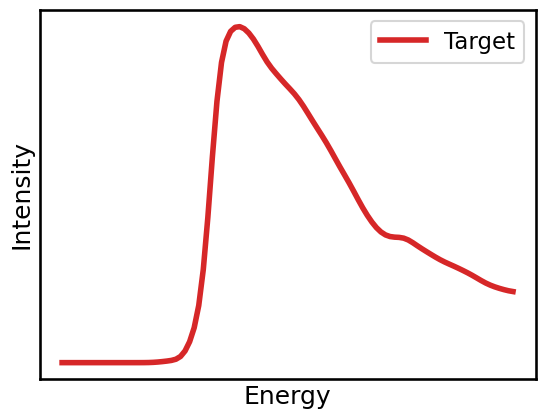

In [26]:
d15_xanes = np.genfromtxt('./data/a-C/dgp/xanes/train/d1.5_1.txt')
d20_xanes = np.genfromtxt('./data/a-C/dgp/xanes/train/d2.0_1.txt')
d25_xanes = np.genfromtxt('./data/a-C/dgp/xanes/train/d2.5_1.txt')
d35_xanes = np.genfromtxt('./data/a-C/dgp/xanes/train/d3.5_2.txt')

target_y = d35_xanes.mean(axis=0, keepdims=True)
target_y = torch.tensor(target_y, dtype=torch.float, device=device)

plt.plot(target_y.squeeze().cpu(), linewidth=4, color='tab:red', label='Target')
plt.legend()
plt.xlabel('Energy')
plt.ylabel('Intensity')
plt.xticks([])
plt.yticks([])
plt.show()

### Generate!

Check the prior score vs. the likelihood score. In order to see conditioning effect, the magnitude of the likelihood term should be comparable to, or even greater than, that of the prior.

In [27]:
import functools
from tqdm.notebook import trange

# Setup
NUM_GEN = 1
BOX_DIM = [16.]*3
box = torch.tensor(BOX_DIM).to(device)
cell = torch.diag(box)
score_net.ema_model.to(device)
xanes_net.ema_model.to(device)

# Likelihood score model
likelihood_score = LikelihoodScore_Chung(score_model=score_net.ema_model, forward_model=xanes_net.ema_model, y=target_y, rho=800.0)

posteriors = []
with torch.no_grad():
    for i in trange(NUM_GEN):
        print(f'Structure {i} -----------------------------------------------')
        # Start with a random initialization
        density = d20_density
        num_nodes = int(density * np.prod(BOX_DIM))
        pos = torch.empty(num_nodes, 3, device=device).uniform_(0, BOX_DIM[0])
        
        # Generate by SDE
        pos_traj = denoise_by_sde(pos, cell, cond_score, ts=torch.linspace(0.999, 0.001, 64+1))

        # 'Restart' sampling really helps avoid CN1 carbon generation
        for _ in range(4):
            pos, _ = diffuser.forward_noise(pos, t=0.4)
            pos_traj_ = denoise_by_sde(pos, cell, prior_score, ts=torch.linspace(0.4, 0.001, 25+1))
            pos = pos_traj_[-1]
        
        # Convert generation to ASE Atoms
        atoms = ase.Atoms(numbers=[6]*len(pos), positions=pos_traj[-1].detach().cpu().numpy(), cell=cell.cpu().numpy(), pbc=[True]*3)
        atoms.wrap()
        posteriors.append(atoms)

        # Check coordination numbers
        CN = coord_num(pos, cutoff=1.8, cell=cell)
        print(f'  Coordination (final): {torch.bincount(CN).cpu().numpy()}')

  0%|          | 0/1 [00:00<?, ?it/s]

Structure 0 -----------------------------------------------
p-score norm: 9.072, l-score norm: 486.493, tgt norm: 1.1016
p-score norm: 9.665, l-score norm: 427.435, tgt norm: 1.0888
p-score norm: 9.971, l-score norm: 374.234, tgt norm: 1.1239
p-score norm: 10.711, l-score norm: 606.305, tgt norm: 1.1360
p-score norm: 11.334, l-score norm: 458.004, tgt norm: 1.1082
p-score norm: 11.994, l-score norm: 389.959, tgt norm: 1.1283
p-score norm: 12.709, l-score norm: 429.217, tgt norm: 1.1385
p-score norm: 13.774, l-score norm: 446.563, tgt norm: 1.1560
p-score norm: 14.504, l-score norm: 395.883, tgt norm: 1.1476
p-score norm: 15.343, l-score norm: 379.800, tgt norm: 1.1547
p-score norm: 16.114, l-score norm: 339.741, tgt norm: 1.1251
p-score norm: 17.276, l-score norm: 412.256, tgt norm: 1.1302
p-score norm: 18.635, l-score norm: 312.405, tgt norm: 1.1241
p-score norm: 19.633, l-score norm: 571.849, tgt norm: 1.1190
p-score norm: 20.043, l-score norm: 766.973, tgt norm: 1.1182
p-score norm:

### Save generations

In [28]:
import ase

# Save all generations
# for i, atoms in enumerate(posteriors):
    # ase.io.write(f'./tmp/post-tgt-is-d35/{i}.extxyz', atoms)

# Save the last denosing trajectory
denoise_traj = [ase.Atoms(numbers=[6]*len(pos), positions=pos.cpu().numpy(), cell=cell.cpu().numpy(), pbc=[True]*3) for pos in pos_traj]
for atoms in denoise_traj: atoms.wrap()
ase.io.write('./tmp/denoise-traj-posterior_.extxyz', denoise_traj)